In [1]:
import numpy as np
from functools import partial
from typing import overload, Callable, Iterable, List, TypeVar, Any, Literal, Union, Sequence, Tuple, Optional

import torch
from jax.tree_util import tree_flatten, tree_unflatten


T = TypeVar("T")
T1 = TypeVar("T1")
T2 = TypeVar("T2")
T3 = TypeVar("T3")


@overload
def safe_map(f: Callable[[T1], T], __arg1: Iterable[T1]) -> List[T]: ...


@overload
def safe_map(f: Callable[[T1, T2], T], __arg1: Iterable[T1], __arg2: Iterable[T2]) -> List[T]: ...


@overload
def safe_map(f: Callable[[T1, T2, T3], T], __arg1: Iterable[T1], __arg2: Iterable[T2], __arg3: Iterable[T3]) -> List[T]: ...


@overload
def safe_map(f: Callable[..., T], __arg1: Iterable[Any], __arg2: Iterable[Any], __arg3: Iterable[Any], __arg4: Iterable[Any], *args) -> List[T]: ...


def safe_map(f, *args):
    args = list(map(list, args))
    n = len(args[0])
    for arg in args[1:]:
        assert len(arg) == n, f'length mismatch: {list(map(len, args))}'
    return list(map(f, *args))



def slice_along_axis(start, end, stride=None, axis=0):
    return (slice(None),) * axis + (slice(start, end, stride),)

def _interleave(a, b, axis):
    # https://stackoverflow.com/questions/60869537/how-can-i-interleave-5-pytorch-tensors
    if b_trunc := (a.shape[axis] == b.shape[axis] + 1):
        pad = [0, 0] * b.ndim
        pad[(b.ndim-axis-1)*2+1] = 1 # +1=always end of dim, pad-order is reversed so start is at end
        b = torch.nn.functional.pad(b, pad)

    stacked = torch.stack([a, b], dim=axis+1)
    interleaved = torch.flatten(stacked, start_dim=axis, end_dim=axis+1)
    if b_trunc:
        # TODO: find torch alternative for slice_along axis for torch.jit.script to work
        interleaved = interleaved[slice_along_axis(0, b.shape[axis]+a.shape[axis]-1, axis=axis)]
    return interleaved

def test_interleave():
    x,y = torch.randn(1, 32, 32), torch.randn(1, 32, 32)
    v = _interleave(x,y, axis=1)
    assert v.shape == (1,64,32)
    assert (v[:, 0] == x[:, 0]).all()
    assert (v[:, 1] == y[:, 0]).all()
    assert (v[:, 2] == x[:, 1]).all()
    assert (v[:, 3] == y[:, 1]).all()
    assert (v[:, 4] == x[:, 2]).all()

    v = _interleave(x,y, axis=2)
    assert v.shape == (1,32,64)
    assert (v[..., 0] == x[..., 0]).all()
    assert (v[..., 1] == y[..., 0]).all()
    assert (v[..., 2] == x[..., 1]).all()
    assert (v[..., 3] == y[..., 1]).all()
    assert (v[..., 4] == x[..., 2]).all()

    x,y = torch.randn(1, 24, 24), torch.randn(1, 24, 24)
    assert _interleave(x,y, axis=1).shape == (1,48,24)
    assert _interleave(x,y, axis=2).shape == (1,24,48)

    x,y = torch.randn(3, 96), torch.randn(2, 96)
    v = _interleave(x,y,axis=0)
    assert v.shape == (5, 96)
    assert (v[0] == x[0]).all()
    assert (v[1] == y[0]).all()
    assert (v[2] == x[1]).all()
    assert (v[3] == y[1]).all()
    assert (v[4] == x[2]).all()
    print('Interleave working as expected!')


# Pytorch impl. of jax.lax.associative_scan
def associative_scan(operator, elems, axis=0, reverse=False):
    if not callable(operator):
        raise TypeError("lax.associative_scan: fn argument should be callable.")
    elems_flat, tree = tree_flatten(elems)

    if reverse:
        elems_flat = [torch.flip(elem, [axis]) for elem in elems_flat]

    def combine(a_flat, b_flat):
        # Lower `fn` to operate on flattened sequences of elems.
        a = tree_unflatten(tree, a_flat)
        b = tree_unflatten(tree, b_flat)
        c = operator(a, b)
        c_flat, _ = tree_flatten(c)
        return c_flat

    assert axis >= 0 or axis < elems_flat[0].ndim, "Axis should be within bounds of input"
    num_elems = int(elems_flat[0].shape[axis])
    if not all(int(elem.shape[axis]) == num_elems for elem in elems_flat[1:]):
        raise ValueError('Array inputs to associative_scan must have the same '
                         'first dimension. (saw: {})'
                         .format([elem.shape for elem in elems_flat]))

    def _scan(elems):
        """Perform scan on `elems`."""
        num_elems = elems[0].shape[axis]

        if num_elems < 2:
            return elems

        # Combine adjacent pairs of elements.
        reduced_elems = combine(
          [elem[slice_along_axis(0, -1, stride=2, axis=axis)] for elem in elems],
          [elem[slice_along_axis(1, None, stride=2, axis=axis)] for elem in elems])

        # Recursively compute scan for partially reduced tensors.
        odd_elems = _scan(reduced_elems)

        if num_elems % 2 == 0:
            even_elems = combine(
                [e[slice_along_axis(0, -1, axis=axis)] for e in odd_elems],
                [e[slice_along_axis(2, None, stride=2, axis=axis)] for e in elems])
        else:
            even_elems = combine(
                odd_elems,
                [e[slice_along_axis(2, None, stride=2, axis=axis)] for e in elems])

        # The first element of a scan is the same as the first element
        # of the original `elems`.
        even_elems = [
          torch.cat([elem[slice_along_axis(0, 1, axis=axis)], result], dim=axis)
          if result.shape.numel() > 0 and elem.shape[axis] > 0 else
          result if result.shape.numel() > 0 else
          elem[slice_along_axis(0, 1, axis=axis)]  # Jax allows/ignores concat with 0-dim, Pytorch does not
          for (elem, result) in zip(elems, even_elems)]

        return list(safe_map(partial(_interleave, axis=axis), even_elems, odd_elems))

    scans = _scan(elems_flat)

    if reverse:
        scans = [torch.flip(scanned, [axis]) for scanned in scans]

    return tree_unflatten(tree, scans)

def nested_func(a,b):
    a_i,b_i = a
    a_j,b_j = b
    return a_j*a_i, a_j*b_i + b_j

def test_associative_scan(shape=(1, 24, 24)):
    import jax.lax
    import jax

    x = np.random.randn(*shape)
    jx = jax.numpy.array(x)
    tx = torch.tensor(x, dtype=torch.float32)
    
    jy1, jy2 = jax.lax.associative_scan(nested_func, (jx, jx))
    ty1, ty2 = associative_scan(nested_func, (tx,tx))
    assert np.isclose(ty1.numpy(), np.array(jy1)).all() and np.isclose(ty2.numpy(), np.array(jy2)).all(), "Expected jax & pytorch impl to be close"

    jy1, jy2 = jax.lax.associative_scan(nested_func, (jx, jx), reverse=True)
    ty1, ty2 = associative_scan(nested_func, (tx,tx), reverse=True)
    assert np.isclose(ty1.numpy(), np.array(jy1)).all() and np.isclose(ty2.numpy(), np.array(jy2)).all(), "Expected jax & pytorch reverse impl to be close"
    

In [2]:
import timeit

B, T, D = 2, 32, 16
T_list = [2 ** power for power in range(7, 18)]

execution_times = []

for index, T in enumerate(T_list):
    # Generate random input data
    input_sequence = torch.randn(B, T, D)
    Lambda_bar = torch.rand(D)
    Lambda_elements = Lambda_bar * np.ones((1, T, D))

    # Time the execution of the code
    if index == 0:
        print("Lambda_elements's shape is", Lambda_elements.shape)
        print("input_sequence's shape is", input_sequence.shape)
    execution_time = timeit.timeit(lambda: associative_scan(nested_func, (Lambda_elements, input_sequence), axis=1), number=7)

    # Append the execution time to the list
    execution_times.append(execution_time)

Lambda_elements's shape is torch.Size([1, 128, 16])
input_sequence's shape is torch.Size([2, 128, 16])


In [3]:

from scipy.optimize import curve_fit

# Define the fitting functions
def polynomial_fit(T, a, b, c):
    return a * T**2 + b * T + c

def logarithmic_fit(T, a, b, c, d, e):
    return a * T * np.log(T) + b * T + c * np.log(T) + d + e * T ** 0.5

# Fit the data with polynomial and logarithmic functions
params_poly, _ = curve_fit(polynomial_fit, T_list, np.log(execution_times))
params_log, _ = curve_fit(logarithmic_fit, T_list, np.log(execution_times))


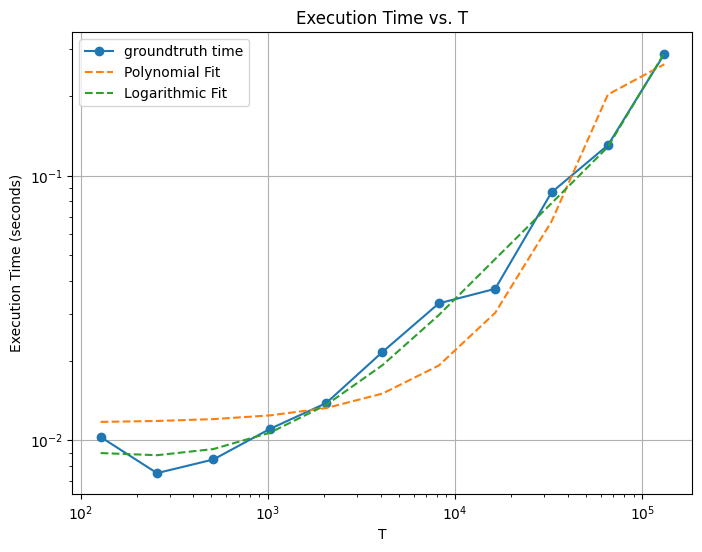

In [4]:

import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(8, 6))
plt.loglog(T_list, execution_times, marker='o', linestyle='-', label="groundtruth time")
plt.plot(T_list, np.exp(polynomial_fit(np.array(T_list), *params_poly)), linestyle='--', label='Polynomial Fit')
plt.plot(T_list, np.exp(logarithmic_fit(np.array(T_list), *params_log)), linestyle='--', label='Logarithmic Fit')
plt.xlabel('T')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. T')
plt.grid(True)
plt.legend()

# Save the plot to a file or display it
plt.savefig('execution_time_vs_T.png')
plt.show()